In [17]:
import pandas as pd
file_path = "SubscriptionUseCase_Dataset.xlsx"
subs = pd.read_excel(file_path, sheet_name="Subscriptions")
plans = pd.read_excel(file_path, sheet_name="Subscription_Plans")
billing = pd.read_excel(file_path, sheet_name="Billing_Information")
#Step 1: Average spend per subscription
avg_spend = billing.groupby("subscription_id")["amount"].mean().reset_index(name="avg_spend")
# --- Step 2: Merge with subscriptions and plans ---
subs_small = subs[["Subscription Id", "User Id", "Product Id"]].rename(
    columns={"Subscription Id":"subscription_id", "Product Id":"product_id"}
)
plans_small = plans[["Product Id", "Price"]].rename(
    columns={"Product Id":"product_id", "Price":"plan_price"}
)

df = subs_small.merge(avg_spend, on="subscription_id", how="left") \
               .merge(plans_small, on="product_id", how="left")

df["avg_spend"] = df["avg_spend"].fillna(0)

# --- Step 3: Recommendation function ---
plans_sorted = plans_small.drop_duplicates().sort_values("plan_price")

def recommend_plan(avg_amount):
    candidates = plans_sorted[plans_sorted["plan_price"] >= avg_amount]
    if not candidates.empty:
        return candidates.iloc[0]["product_id"]
    else:
        return plans_sorted.iloc[-1]["product_id"]

df["recommended_plan_id"] = df["avg_spend"].apply(recommend_plan)
recommendations = df[["subscription_id", "User Id", "product_id", "avg_spend", "recommended_plan_id"]]

print(recommendations.head(10))


   subscription_id  User Id  product_id   avg_spend  recommended_plan_id
0                1       61          46  275.090000                 50.0
1                2       37          35    0.000000                 83.0
2                3       24          96   73.470000                 12.0
3                4       69          79  319.475000                 50.0
4                5        3          52  279.786667                 50.0
5                6       86          33  407.490000                 50.0
6                7       45          31   46.860000                 82.0
7                8       28          17  136.460000                 50.0
8                9       97          14    0.000000                 83.0
9               10       26          63  372.936667                 50.0


Key Feature : personalized Recommendation
The goal is to recommend the best-fit subscription plan
for each user based on their historical spending behavior.
Algorithm used: A rule-based matching algorithm:
If average spend ≤ plan price → recommend the cheapest suitable plan.
If spend > all plan prices → recommend the most expensive plan.
Output: For each user, we get their current plan, average spend, and a recommended best-fit plan.

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
file_path = "SubscriptionUseCase_Dataset.xlsx"
subs = pd.read_excel(file_path, sheet_name="Subscriptions")
billing = pd.read_excel(file_path, sheet_name="Billing_Information")
# --- Step 1: Feature Engineering ---
renewal_count = billing[billing["payment_status"]=="paid"].groupby("subscription_id").size().reset_index(name="renewal_count")
avg_spend = billing.groupby("subscription_id")["amount"].mean().reset_index(name="avg_spend")
last_billed = billing.groupby("subscription_id")["billing_date"].max().reset_index(name="last_billed")
subs_small = subs[["Subscription Id", "User Id", "Start Date", "Terminated Date", "Status"]] \
              .rename(columns={"Subscription Id":"subscription_id"})

df = subs_small.merge(renewal_count, on="subscription_id", how="left") \
               .merge(avg_spend, on="subscription_id", how="left") \
               .merge(last_billed, on="subscription_id", how="left")

df[["renewal_count","avg_spend"]] = df[["renewal_count","avg_spend"]].fillna(0)
today = pd.to_datetime("2025-09-13")
df["Start Date"] = pd.to_datetime(df["Start Date"], errors="coerce")
df["Terminated Date"] = pd.to_datetime(df["Terminated Date"], errors="coerce")
df["end_date"] = df["Terminated Date"].fillna(df["last_billed"]).fillna(today)
df["duration_days"] = (df["end_date"] - df["Start Date"]).dt.days.clip(lower=0).fillna(0)

# --- Step 2: Labels ---
# Assume: active = Renew, otherwise = Churn
df["label"] = df["Status"].str.lower().apply(lambda x: "Renew" if x=="active" else "Churn")

# --- Step 3: Train Logistic Regression ---
X = df[["renewal_count","avg_spend","duration_days"]]
y = (df["label"]=="Renew").astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# --- Step 4: Predictions ---
df["predicted"] = model.predict(X)
df["predicted"] = df["predicted"].map({1:"Renew", 0:"Churn"})

# --- Step 5: Output ---
result = df[["subscription_id","User Id","renewal_count","avg_spend","duration_days","predicted"]]
print(result.head(10))


   subscription_id  User Id  renewal_count   avg_spend  duration_days  \
0                1       61            0.0  275.090000             86   
1                2       37            0.0    0.000000            385   
2                3       24            0.0   73.470000             39   
3                4       69            0.0  319.475000              9   
4                5        3            3.0  279.786667            109   
5                6       86            1.0  407.490000             44   
6                7       45            1.0   46.860000            176   
7                8       28            1.0  136.460000             12   
8                9       97            0.0    0.000000            529   
9               10       26            1.0  372.936667            224   

  predicted  
0     Churn  
1     Churn  
2     Renew  
3     Churn  
4     Renew  
5     Renew  
6     Renew  
7     Renew  
8     Churn  
9     Churn  


In [ ]:
Churn Predction:
Objective: Predict whether a user will renew their subscription or churn (cancel)
Algorithm: Logistic Regression (Supervised Machine Learning)
It is a classification algorithm used to predict binary outcomes.
output: Churn or Renew

In [12]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
file_path = "SubscriptionUseCase_Dataset.xlsx"

subs = pd.read_excel(file_path, sheet_name="Subscriptions")
billing = pd.read_excel(file_path, sheet_name="Billing_Information")

# --- Step 1: Feature Engineering ---
renewal_count = billing[billing["payment_status"]=="paid"].groupby("subscription_id").size().reset_index(name="renewal_count")
avg_spend = billing.groupby("subscription_id")["amount"].mean().reset_index(name="avg_spend")
last_billed = billing.groupby("subscription_id")["billing_date"].max().reset_index(name="last_billed")
subs_small = subs[["Subscription Id","User Id","Start Date","Terminated Date"]].rename(columns={"Subscription Id":"subscription_id"})

df = subs_small.merge(renewal_count, on="subscription_id", how="left") \
               .merge(avg_spend, on="subscription_id", how="left") \
               .merge(last_billed, on="subscription_id", how="left")

df[["renewal_count","avg_spend"]] = df[["renewal_count","avg_spend"]].fillna(0)
today = pd.to_datetime("2025-09-13")
df["Start Date"] = pd.to_datetime(df["Start Date"], errors="coerce")
df["Terminated Date"] = pd.to_datetime(df["Terminated Date"], errors="coerce")
df["end_date"] = df["Terminated Date"].fillna(df["last_billed"]).fillna(today)
df["duration_days"] = (df["end_date"] - df["Start Date"]).dt.days.clip(lower=0).fillna(0)

# --- Step 2: Clustering ---
features = df[["renewal_count","avg_spend","duration_days"]]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

kmeans = KMeans(n_clusters=3, random_state=42)
df["cluster"] = kmeans.fit_predict(X_scaled)

# --- Step 3: Label clusters (Heavy/Medium/Light) ---
cluster_order = df.groupby("cluster")["avg_spend"].mean().sort_values(ascending=False).index.tolist()
label_map = {cluster_order[0]:"Heavy", cluster_order[1]:"Medium", cluster_order[2]:"Light"}
df["user_segment"] = df["cluster"].map(label_map)

# --- Step 4: Output ---
result = df[["subscription_id","User Id","renewal_count","avg_spend","duration_days","user_segment"]]
print(result.head(10))

# Segment counts
print("\nSegment distribution:")
print(result["user_segment"].value_counts())


   subscription_id  User Id  renewal_count   avg_spend  duration_days  \
0                1       61            0.0  275.090000             86   
1                2       37            0.0    0.000000            385   
2                3       24            0.0   73.470000             39   
3                4       69            0.0  319.475000              9   
4                5        3            3.0  279.786667            109   
5                6       86            1.0  407.490000             44   
6                7       45            1.0   46.860000            176   
7                8       28            1.0  136.460000             12   
8                9       97            0.0    0.000000            529   
9               10       26            1.0  372.936667            224   

  user_segment  
0       Medium  
1        Light  
2       Medium  
3       Medium  
4        Heavy  
5       Medium  
6       Medium  
7       Medium  
8        Light  
9       Medium  

Segment 

In [ ]:
Customer Prediction:
Objective: Group users into Heavy, Medium, and Light subscribers based on renewal count, average spend, and subscription duration.
Algorithm Used: K-Means Clustering – an unsupervised machine learning algorithm that groups similar users together.
Output: Heavy, Medium, Light

INFO:prophet:n_changepoints greater than number of observations. Using 7.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnewempi3/8_kxo0l8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnewempi3/qrsfmab6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57761', 'data', 'file=/tmp/tmpnewempi3/8_kxo0l8.json', 'init=/tmp/tmpnewempi3/qrsfmab6.json', 'output', 'file=/tmp/tmpnewempi3/prophet_modelnrl7s4_q/prophet_model-20250913053112.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
05:31:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:31:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


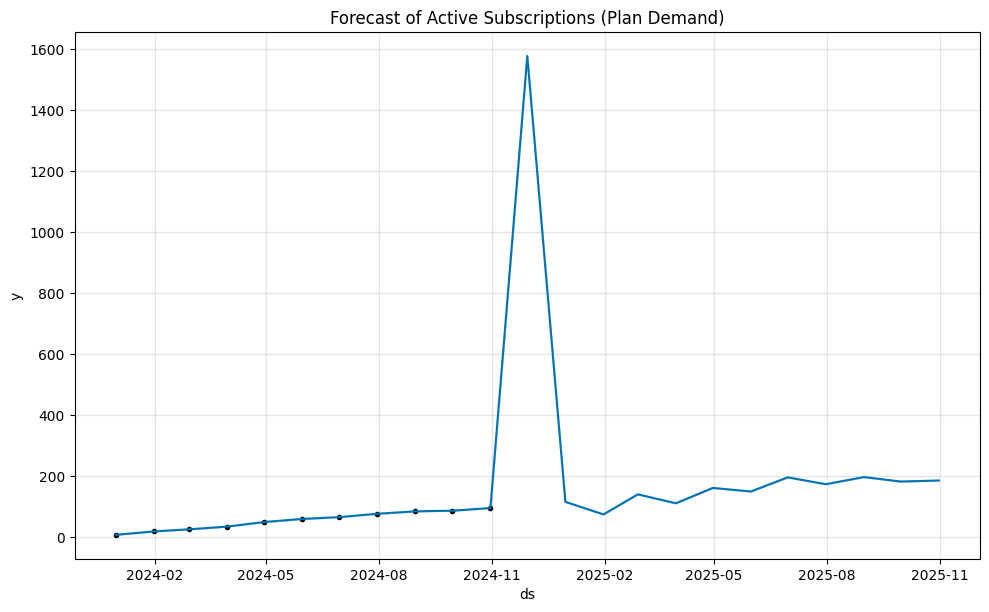

           ds         yhat   yhat_lower   yhat_upper
11 2024-11-30  1578.121816  1578.121816  1578.121816
12 2024-12-31   115.154862   115.154861   115.154862
13 2025-01-31    73.796136    73.796135    73.796136
14 2025-02-28   139.650157   139.650156   139.650157
15 2025-03-31   110.389218   110.389217   110.389220
16 2025-04-30   160.756966   160.756964   160.756968
17 2025-05-31   149.073605   149.073603   149.073607
18 2025-06-30   195.474950   195.474947   195.474953
19 2025-07-31   172.997759   172.997756   172.997763
20 2025-08-31   196.425043   196.425040   196.425047
21 2025-09-30   181.726823   181.726819   181.726827
22 2025-10-31   185.130680   185.130676   185.130686


In [16]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
file_path = "SubscriptionUseCase_Dataset.xlsx"
subs = pd.read_excel(file_path, sheet_name="Subscriptions")

# --- Step 1: Prepare data (use ME instead of M) ---
subs["Start Date"] = pd.to_datetime(subs["Start Date"], errors="coerce")
subs["Terminated Date"] = pd.to_datetime(subs["Terminated Date"], errors="coerce")

date_range = pd.date_range(subs["Start Date"].min(), subs["Start Date"].max(), freq="ME")
time_series = []

for d in date_range:
    active_count = ((subs["Start Date"] <= d) & ((subs["Terminated Date"].isna()) | (subs["Terminated Date"] >= d))).sum()
    time_series.append([d, active_count])

df = pd.DataFrame(time_series, columns=["ds","y"])

# --- Step 2: Forecast using Prophet (with yearly seasonality) ---
model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
model.fit(df)

future = model.make_future_dataframe(periods=12, freq="ME")  # forecast next 12 months
forecast = model.predict(future)

# --- Step 3: Plot forecast ---
fig1 = model.plot(forecast)
plt.title("Forecast of Active Subscriptions (Plan Demand)")
plt.show()

# --- Step 4: Output forecast values ---
print(forecast[["ds","yhat","yhat_lower","yhat_upper"]].tail(12))


Forecasting Subsricption:
Objective:To forecast future subscription demand (active subscribers per month) based on historical subscription
start and termination data
**Algorithm:** Facebook Prophet – a time series forecasting algorithm that automatically models trend + seasonality + holidays.
It is robust to missing data and handles yearly seasonality effectively.
**Output:** The table shows the forecasted number of active subscriptions (yhat) for the next 12 months, representing the expected plan demand trend